# Visualize Result of PHILHARMONIC Analysis

In [4]:
# @title Download and Install PHILHARMONIC

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/samsledje/philharmonic.git
    !cd philharmonic; pip install -e .
    !curl https://current.geneontology.org/ontology/go.obo -o go.obo
    !curl https://current.geneontology.org/ontology/subsets/goslim_generic.obo -o goslim_generic.obo

from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from matplotlib import pyplot as plt

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
    parse_GO_map,
    plot_cluster,
    print_cluster,
    write_cluster_cytoscape,
)

In [7]:
# @title Loading PHILHARMONIC results
# @markdown Upload your zipped results file using the "Files" tab to the left.
# @markdown Set the `RUN_NAME` variable to the name of the run from your config file you want to analyze
# @markdown If you are running this locally, edit the `RESULTS_DIR` variable to point to your results directory, and point to a locally downloaded go.obo file.

ZIP_FILE_NAME = ""  # @param {"type":"string","placeholder":"philharmonic_results.zip"}
RUN_NAME = ""  # @param {"type":"string","placeholder":"philharmonic_run"}
RESULTS_DIR = "."  # @param {"type":"string","placeholder":"."}

if IN_COLAB:
    from google.colab import files

    !unzip $ZIP_FILE_NAME
    results_dir = Path(".")
    GO_OBO_PATH = "go.obo"
else:
    RESULTS_DIR = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/"
    results_dir = Path(RESULTS_DIR)
    GO_OBO_PATH = results_dir / "go.obo"

In [8]:
# @title Load Files
CLUSTER_FILE_PATH = results_dir / f"{RUN_NAME}_clusters.json"
NETWORK_FILE_PATH = results_dir / f"{RUN_NAME}_network.positive.tsv"
GO_MAP_PATH = results_dir / f"{RUN_NAME}_GO_map.csv"
IMG_DIR = results_dir / "img"
!mkdir -p $IMG_DIR

clusters = load_cluster_json(CLUSTER_FILE_PATH)
full_G = nx.read_weighted_edgelist(NETWORK_FILE_PATH)
go_map = parse_GO_map(GO_MAP_PATH)
go_database = parse_GO_database(GO_OBO_PATH)

---

## Basic Network Statistics

In [ ]:
label = ["Nodes", "Edges", "Degree (Med)", "Degree (Avg)", "Sparsity"]
degrees = [i[1] for i in list(full_G.degree())]
value = [
    len(full_G.nodes),
    len(full_G.edges),
    np.median(degrees),
    np.mean(degrees),
    len(full_G.edges()) / len(full_G) ** 2,
]
df = pd.DataFrame([label, value]).T
df.columns = ["", "Network"]
df = df.set_index("")
df

,Network
,
Nodes,7267
Edges,348278
Degree (Med),37.0
Degree (Avg),95.851933
Sparsity,0.006595


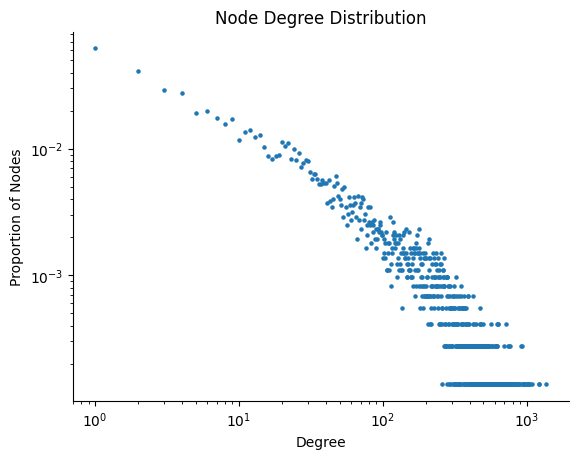

In [5]:
degreeDist = {}
for i in degrees:
    n = degreeDist.setdefault(i, 0)
    degreeDist[i] = n + 1

plt.scatter(degreeDist.keys(), [i / len(full_G) for i in degreeDist.values()], s=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Proportion of Nodes")
plt.title("Node Degree Distribution")
plt.savefig(IMG_DIR / "degree_distribution.svg", bbox_inches="tight", dpi=300)
sns.despine()

---

## Basic Cluster Statistics

In [6]:
logger.info(f"Number of clusters: {len(clusters)}")

2024-10-21 11:04:17.665 | INFO     | __main__:<module>:1 - Number of clusters: 468


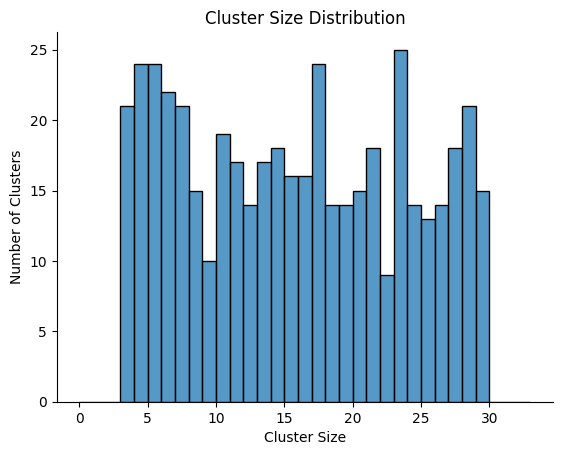

In [7]:
sizes = [len(i["members"]) for i in clusters.values()]
sns.histplot(sizes, bins=np.arange(0, max(sizes) + 5, max(sizes) // 20))
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plt.title("Cluster Size Distribution")
sns.despine()
plt.savefig(IMG_DIR / "size_distribution.svg", bbox_inches="tight", dpi=300)
plt.show()

---

## Overall ReCIPE Stats

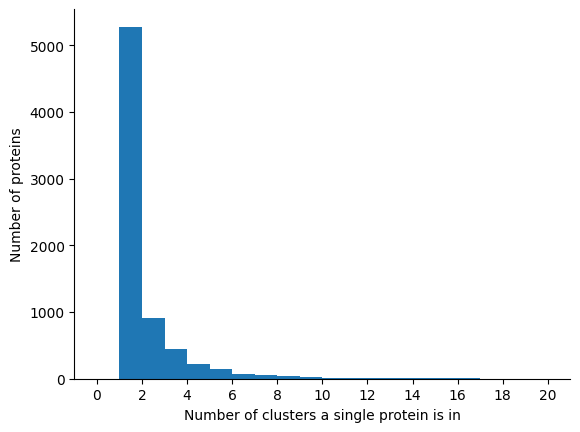

In [8]:
from collections import Counter

node_appearances = list()
for clust in clusters.values():
    for mn in clust["members"]:
        node_appearances.append(mn)
    for rn in clust["recipe"]["degree"]["0.75"]:
        node_appearances.append(rn)
nodes_counter = Counter(node_appearances)
plt.hist(nodes_counter.values(), bins=np.arange(0, 21, 1))
# xtick labels every 5
plt.xticks(np.arange(0, 21, 2))
plt.xlabel("Number of clusters a single protein is in")
plt.ylabel("Number of proteins")
sns.despine()
plt.savefig(IMG_DIR / "protein_number_of_clusters.png", bbox_inches="tight", dpi=300)
plt.show()

---

## View Individual Clusters

In [9]:
# k = "1495076087230339862" # Temperature Regulation
k = "803905878821692717"  # Neurophysical Response

Cluster of 12 proteins [pdam_00001381-RA, pdam_00006156-RA, pdam_00012376-RA, ...] (hash 803905878821692717)
8 proteins re-added by ReCIPE (degree, 0.75)
Edges: 8
Triangles: 0
Max Degree: 3
Top Terms:
		GO:0001964 - <startle response> (9)
		GO:0098703 - <calcium ion import across plasma membrane> (9)
		GO:0045188 - <regulation of circadian sleep/wake cycle, non-REM sleep> (9)
		GO:0071805 - <potassium ion transmembrane transport> (7)
		GO:0071361 - <cellular response to ethanol> (7)
		GO:0001988 - <positive regulation of heart rate involved in baroreceptor response to decreased systemic arterial blood pressure> (7)
		GO:0017085 - <response to insecticide> (7)
		GO:0035095 - <behavioral response to nicotine> (7)
		GO:0060013 - <righting reflex> (7)
		GO:0021771 - <lateral geniculate nucleus development> (7)
		GO:1904645 - <response to amyloid-beta> (7)
		GO:0001941 - <postsynaptic membrane organization> (7)
		GO:0060079 - <excitatory postsynaptic potential> (7)
		GO:0090102 - <cochlea d

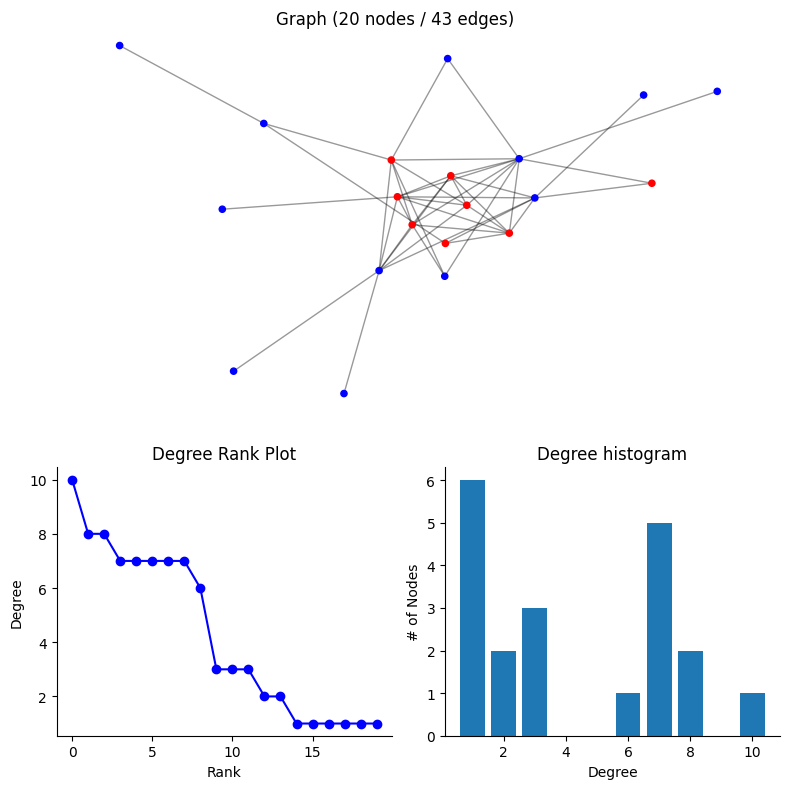

In [10]:
print_cluster(clusters[k], go_database, 20)
plot_cluster(clusters[k], full_G, use_recipe=True, savefig=None)

In [11]:
write_cluster_cytoscape(clusters[k], full_G, f"{k}_cytoscape.txt")